# Gradient-based optimization

In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')

In [2]:
dr.__file__

'/Users/yannizhang/Desktop/RGL/mitsuba3/build/python/drjit/__init__.py'

In [3]:
scene = mi.load_file('scenes/cbox.xml', integrator='prb')
# scene = mi.load_file('scenes/veach-mis.xml', integrator='prb')
# scene = mi.load_file('scenes/mirror.xml', integrator='prb',spp = 32, resx = 64, resy = 64, max_depth = 6)



### Reference image

In [4]:
image_ref = mi.render(scene)
# print(image_ref.numpy())

# Preview the reference image
mi.util.convert_to_bitmap(image_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

In [5]:
params = mi.traverse(scene)
params

SceneParameters[
  ----------------------------------------------------------------------------------------
  Name                                 Flags    Type  Parent
  ----------------------------------------------------------------------------------------
  sensor.near_clip                              float PerspectiveCamera
  sensor.far_clip                               float PerspectiveCamera
  sensor.shutter_open                           float PerspectiveCamera
  sensor.shutter_open_time                      float PerspectiveCamera
  sensor.film.size                              ScalarVector2u HDRFilm
  sensor.film.crop_size                         ScalarVector2u HDRFilm
  sensor.film.crop_offset                       ScalarPoint2u HDRFilm
  sensor.x_fov                         ∂, D     Float PerspectiveCamera
  sensor.to_world                      ∂, D     Transform4f PerspectiveCamera
  gray.reflectance.value               ∂        Color3f SRGBReflectanceSpectrum
  white.re

### Initial state

In [6]:
key = 'red.reflectance.value'
# key = 'white.reflectance.value'
# key = 'DiffuseBSDF.brdf_0.reflectance.value'
# key = 'color_checkerboard.color1.value'




# Save the original value
param_ref = mi.Color3f(params[key])


# Set another color value and update the scene
params[key] = mi.Color3f(0.01, 0.2, 0.9)
# params[key] = mi.Color3f(0,1,0)


params.update();

As expected, when rendering the scene again, the wall has changed color.

In [7]:
image_init = mi.render(scene)
mi.util.convert_to_bitmap(image_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

## Optimization

For gradient-based optimization, Mitsuba ships with standard optimizers including *Stochastic Gradient Descent* ([<code>SGD</code>][1]) with and without momentum, as well as [<code>Adam</code>][2] <cite data-cite="kingma2014adam">[KB14]</cite>. We will instantiate the latter and optimize our scene parameter with a learning rate of `0.05`. 

We then set the color to optimize on the optimizer, which will now hold a copy of this parameter and enable gradient tracking on it. During the optimization process, the optimizer will always perfom gradient steps on those variables. To propagate those changes to the scene, we need to call the `update()` method which will copy the values back into the `params` data structure. As always this method also notifies all objects in the scene whose parameters have changed, in case they need to update their internal state.

This first call to `params.update()` ensures that gradient tracking with respect to our wall color parameter is propagated to the scene internal state. For more detailed explanation on how-to-use the optimizer classes, please refer to the dedicated [how-to-guide][3].

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.SGD
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.Adam
[3]: https://mitsuba.readthedocs.io/en/latest/src/how_to_guides/use_optimizers.html

In [8]:
# opt = mi.ad.Adam(lr=0.05)
# opt = mi.ad.AdamV(lr=0.05)
# opt = mi.ad.AdamVC(lr=0.05)
opt = mi.ad.AdamVCPrint(lr=0.05)
# opt = mi.ad.AdamPrint(lr=0.05)
# opt = mi.ad.AdamVC2(lr=0.05)





opt[key] = params[key]

params.update(opt);

At every iteration of the gradient descent, we will compute the derivatives of the scene parameters with respect to the objective function. In this simple experiment, we use the [*mean square error*][1], or $L_2$ error, between the current image and the reference created above.

[1]: https://en.wikipedia.org/wiki/Mean_squared_error

In [9]:
def mse(image):
    return dr.mean(dr.sqr(image - image_ref))

In the following cell we define the hyper parameters controlling our optimization loop, such as the number of iterations:

In [10]:
iteration_count = 50

In [11]:
# IGNORE THIS: When running under pytest, adjust parameters to reduce computation time
import os
if 'PYTEST_CURRENT_TEST' in os.environ:
    iteration_count = 2

It is now time to actually perform the gradient-descent loop that executes 50 differentiable rendering iterations.

In [12]:
errors = []
err_init = dr.sum(dr.sqr(param_ref - params[key]))
errors.append(err_init)
wp1s =[]
wp2s =[]
param_record = []
suspicious_counter = []
for it in range(iteration_count):
    # Perform a (noisy) differentiable rendering of the scene
    image = mi.render(scene, params, spp =1)

    # Evaluate the objective function from the current rendered image
    loss = mse(image)

    # Backpropagate through the rendering process
    dr.backward(loss, flags = dr.ADFlag.BackPropVarianceCounter | dr.ADFlag.ClearVertices)

    # Optimizer: take a gradient descent step
    wp1,wp2 = opt.step()
    wp1s.append(wp1)
    wp2s.append(wp2)
    if (it > 4 and it < 16) or ( it > 18 and it < 31):
        temp =[]
        temp.append(it)
        temp.append(dr.counter(params[key]))
        suspicious_counter.append(temp)

    # opt.step()

    # Post-process the optimized parameters to ensure legal color values.
    opt[key] = dr.clamp(opt[key], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(opt)
    param_record.append(params[key])
    
    # Track the difference between the current color and the true value
    err_ref = dr.sum(dr.sqr(param_ref - params[key]))
    print(f"Iteration {it:02d}: parameter error = {err_ref[0]:6f}", end='\r')
    errors.append(err_ref)
print('\nOptimization complete.')

Iteration 49: parameter error = 0.000058
Optimization complete.


## Results

We can now render the scene again to check whether the optimization process successfully recovered the color of the red wall.

In [13]:
image_final = mi.render(scene, spp=128)
# mi.util.write_bitmap('/Users/yannizhang/Desktop/RGL/5.10/render2_adam_V_C.png', image_final)
mi.util.convert_to_bitmap(image_final)


Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

It worked!

Note visualizing the objective value directly sometimes gives limited information, since differences between `image` and `image_ref` can be dominated by Monte Carlo noise that is not related to the parameter being optimized. 

Since we know the “true” target parameter in this scene, we can validate the convergence of the optimization by checking the difference to the true color at each iteration:

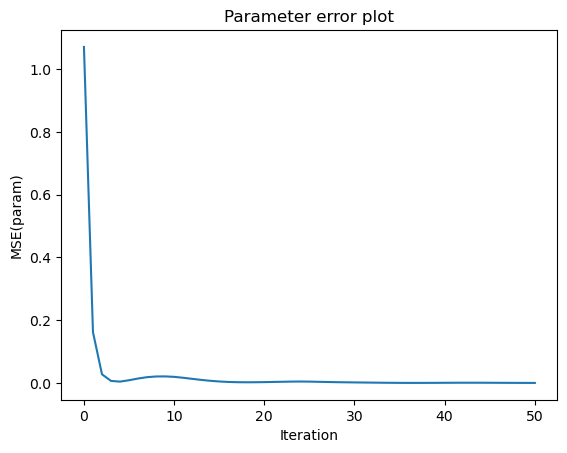

In [14]:
import matplotlib.pyplot as plt
plt.plot(errors)
plt.xlabel('Iteration'); plt.ylabel('MSE(param)'); plt.title('Parameter error plot');
# plt.savefig('/Users/yannizhang/Desktop/RGL/5.10/scene2_adma_V_C.png')
plt.show()

In [15]:
# import numpy as np
# a = np.array(wp1s)
# b = np.array(wp2s)
# plt.plot(a, linestyle='--',label='wp1')
# plt.plot(b, linestyle='-',label='wp2')
# plt.legend()

# plt.xlabel('Iteration'); plt.ylabel('weight 1'); plt.title('Weight 1 & 2 from Adam');
# plt.savefig('/Users/yannizhang/Desktop/adam_weight12.png')
# plt.show()

In [16]:
import numpy as np
a = np.array(wp1s)
b = np.squeeze(a,axis=1)
c = np.squeeze(b,axis=1)

wp1_r = np.log(c[:,0])
wp1_g = np.log(c[:,1])
wp1_b = np.log(c[:,2])

suspicous_r = []
suspicous_g = []
suspicous_b = []

for i in range(1,49):
    if (wp1_r[i-1] < wp1_r[i] and wp1_r[i] > wp1_r[i+1]):
        suspicous_r.append(i)
    if (wp1_g[i-1] < wp1_g[i] and wp1_g[i] > wp1_g[i+1]):
        suspicous_g.append(i)
    if (wp1_b[i-1] < wp1_b[i] and wp1_b[i] > wp1_b[i+1]):
        suspicous_b.append(i)
   

In [17]:
print(suspicous_r)
print(suspicous_g)
print(suspicous_b)

[]
[10]
[24]


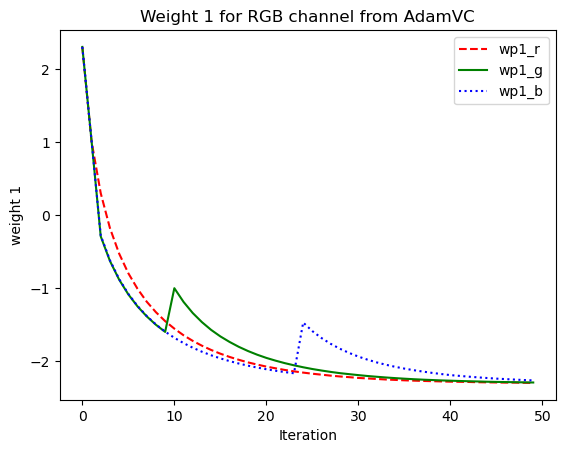

In [18]:



plt.plot(wp1_r, color = 'r', linestyle='--',label='wp1_r')
plt.plot(wp1_g, color = 'g', linestyle='-',label='wp1_g')
plt.plot(wp1_b, color = 'b', linestyle=':',label='wp1_b')
plt.legend()

plt.xlabel('Iteration'); plt.ylabel('weight 1'); plt.title('Weight 1 for RGB channel from AdamVC');
plt.savefig('/Users/yannizhang/Desktop/adamVC_w1.png')
plt.show()


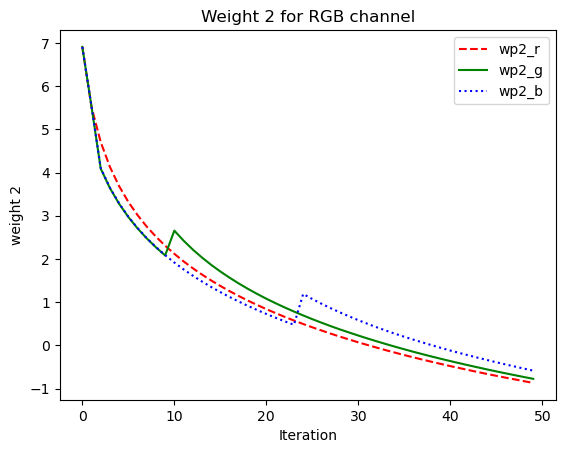

In [19]:
import numpy as np
a = np.array(wp2s)
b = np.squeeze(a,axis=1)
c = np.squeeze(b,axis=1)
plt.plot(np.log(c[:,0]),  color = 'r', linestyle='--',label='wp2_r')
plt.plot(np.log(c[:,1]),  color = 'g', linestyle='-',label='wp2_g')
plt.plot(np.log(c[:,2]),  color = 'b', linestyle=':',label='wp2_b')
plt.legend()

plt.xlabel('Iteration'); plt.ylabel('weight 2'); plt.title('Weight 2 for RGB channel');
plt.savefig('/Users/yannizhang/Desktop/adamVC_w2.png')
plt.show()

In [20]:
for i in range(len(suspicious_counter)):
    print(suspicious_counter[i])

[5, [[57805.0, 25715.0, 25715.0]]]
[6, [[57826.0, 25715.0, 25715.0]]]
[7, [[57715.0, 25715.0, 25715.0]]]
[8, [[57786.0, 25715.0, 25715.0]]]
[9, [[57797.0, 25715.0, 25715.0]]]
[10, [[57869.0, 59354.0, 25715.0]]]
[11, [[57771.0, 59308.0, 25715.0]]]
[12, [[57786.0, 59244.0, 25715.0]]]
[13, [[57811.0, 59262.0, 25715.0]]]
[14, [[57824.0, 59184.0, 25715.0]]]
[15, [[57844.0, 59198.0, 25715.0]]]
[19, [[57930.0, 59154.0, 25715.0]]]
[20, [[57921.0, 59137.0, 25715.0]]]
[21, [[58005.0, 59191.0, 25715.0]]]
[22, [[57963.0, 59195.0, 25715.0]]]
[23, [[57977.0, 59218.0, 25715.0]]]
[24, [[57995.0, 59207.0, 59433.0]]]
[25, [[58009.0, 59176.0, 59304.0]]]
[26, [[58062.0, 59194.0, 59259.0]]]
[27, [[58006.0, 59170.0, 59246.0]]]
[28, [[58007.0, 59151.0, 59206.0]]]
[29, [[58042.0, 59228.0, 59215.0]]]
[30, [[57926.0, 59236.0, 59165.0]]]


In [21]:
for i in range(5,16):
    print(param_record[i])

[[0.5728707313537598, 0.037508219480514526, 0.039872266352176666]]
[[0.5728707313537598, 0.037508219480514526, 0.039872266352176666]]
[[0.5728707313537598, 0.037508219480514526, 0.039872266352176666]]
[[0.5728707313537598, 0.037508219480514526, 0.039872266352176666]]
[[0.5728707313537598, 0.037508219480514526, 0.039872266352176666]]
[[0.5728707313537598, 0.037508219480514526, 0.039872266352176666]]
[[0.5728707313537598, 0.037508219480514526, 0.039872266352176666]]
[[0.5728707313537598, 0.037508219480514526, 0.039872266352176666]]
[[0.5728707313537598, 0.037508219480514526, 0.039872266352176666]]
[[0.5728707313537598, 0.037508219480514526, 0.039872266352176666]]
[[0.5728707313537598, 0.037508219480514526, 0.039872266352176666]]


## See also

- [Detailed look at <code>Optimizer</code>](https://mitsuba.readthedocs.io/en/latest/src/how_to_guides/use_optimizers.html)
- API reference:
  - [<code>mitsuba.ad.Optimizer</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.Optimizer)
  - [<code>mitsuba.ad.integrators.prb</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.integrators.prb)
  - [<code>mitsuba.ad.SGD</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.SGD)
  - [<code>mitsuba.ad.Adam</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.Adam)
  - [<code>drjit.backward</code>](https://drjit.readthedocs.io/en/latest/src/api_reference.html#drjit.backward)